# ESSC4510/EASC5510
## Detecting correlations among data

The following tutorial demonstrates
1. Cross-correlation shifting
2. Bandpass filter design and application
3. Signal processing before bandpass


In [1]:
# eda09_00 clear all variables and import vatious modules
%reset -f
import os
from datetime import date
from math import exp, pi, sin, cos, tan, sqrt, floor, ceil, log
import numpy as np
import scipy.sparse.linalg as las
from scipy import sparse
import scipy.linalg as la
import scipy.signal as sg
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

# eda_draw function makes a "pictorial matrix equation"
# arguments are vectors, matrices and strings
# which are plotted in the order that the appear
# except that strings starting with 'title ' are plotted
# under the subseqeunt matrix or vector
# always returns a status of 1

def eda_draw(*argv):
    bw = np.zeros((256,4));
    v = 0.9*(256 - np.linspace( 0, 255, 256 ))/255;
    bw[:,0] = v;
    bw[:,1] = v;
    bw[:,2] = v;
    bw[:,3] = np.ones(256);
    bwcmap = ListedColormap(bw);
    # size of plot
    W = 16;
    H = 4;
    fig1 = plt.figure(1);
    # figsize width and height in inches
    fig1.set_size_inches(W,H);
    ax1 = plt.subplot(1,1,1);
    plt.axis([0, W, -H/2, H/2]);
    plt.axis('off');
    LM = W/6;    # matrix width and heoght
    LV = W/40;   # vector width
    FS = 0.12;    # character width
    TO = 0.4;    # title vertical offset
    SP = 0.2;    # space between objects
    LS = 0.2;    # leading space
    p = LS; # starting x-position
    istitle=0; # flags presence of a title
    for a in argv:
        if isinstance(a,np.ndarray):
            sh = np.shape(a);
            if len(sh) == 1:  # conversion to nx1 array
                n = sh[0];
                m = 1;
                ap = a;
                a = np.zeros((n,1));
                a[:,0] = ap;
            else:
                n = sh[0];
                m = sh[1];
            if m==1:
                pold=p;
                left=p;
                right=p+LV;
                bottom=-LM/2;
                top=LM/2;
                plt.imshow( a, cmap=bwcmap, vmin=np.min(a), vmax=np.max(a), extent=(left,right,bottom,top) );
                p = p+LV;
                pm = (p+pold)/2;
                if istitle:
                    plt.text(pm,-(LM/2)-TO,titlestr,horizontalalignment='center');
                    istitle=0;
                p = p+SP;
            else:
                pold=p;
                left=p;
                right=p+LM;
                bottom=-LM/2;
                top=LM/2;
                plt.imshow( a, cmap=bwcmap, vmin=np.min(a), vmax=np.max(a), extent=(left,right,bottom,top) );
                p = p+LM;
                pm = (p+pold)/2;
                if istitle:
                    plt.text(pm,-(LM/2)-TO,titlestr,horizontalalignment='center');
                    istitle=0;
                p = p+SP;
        elif isinstance(a,str):
            ns = len(a);
            istitle=0;
            if( ns>=6 ):
                if 'title ' in a[0:6]:
                    istitle=1;
                    titlestr=a[6:];
            if( istitle != 1):
                plt.text(p,0,a);
                p = p + ns*FS + SP;
    plt.show();
    return 1;


def FTFmul(v):
    # this function is used by the bicongugate gradient solver to solve the geneneralized least
    # squares problem Fm=f.  Note that "F" must be called "edaFsparse".
    global edaFsparse;
    s = np.shape(v);
    if(len(s)==1):
        vv = np.zeros((s[0],1));
        vv[:,0] = v;
    else:
        vv=v;
    temp = edaFsparse*vv;
    return edaFsparse.transpose()*temp;


def GLSFilterMul(v):
    # this function is used by the bicongugate gradient solver to solve the
    # geneneralized least squares problem Fm=f with F=[G;H] and f=[d,h],
    # where G is a topplitz matrix built from the filter g
    # Note that "H" must be sparese and called "edaHsparse" and that
    # the filter "g" bust be called edafilterg and must be a column vector
    global edaHsparse;
    global edafilterg;
    # rearrange as column-vector
    s = np.shape(v);
    M = s[0];
    if(len(s)==1):
        vv = np.zeros((s[0],1));
        vv[:,0] = v;
    else:
        vv=v;
    N, i = np.shape(edafilterg);
    # implements (GT G + HT H) v
    temp1 = np.zeros((N+M-1,1));
    temp1[:,0] = np.convolve(edafilterg.ravel(),vv.ravel()); # G v is of length N
    a = np.zeros((N,1));
    a[:,0] = temp1[0:N,0];
    b = edaHsparse * v; # H v is of length K
    temp2 = np.zeros((N+N-1,1));
    temp2[:,0] = np.convolve((np.flipud(edafilterg)).ravel(),a.ravel()); # GT (G v) is of length M
    a2 = temp2[N-1:N+M-1,0];
    b2 = edaHsparse.transpose()*b; # HT (H v) is of length M
    # FT F v = GT G v + HT H v
    return (a2+b2);


def GLSautoMul(v):
    # this function is used by the bicongugate gradient solver to solve the
    # geneneralized least squares problem Fm=f with F=[G;H] and f=[d,h],
    # where GTG is built from the autocorrelation of the filter g
    global edaHsparse;
    global edaautoc;
    # rearrange as column-vector
    s = np.shape(v);
    M = s[0];
    if(len(s)==1):
        vv = np.zeros((s[0],1));
        vv[:,0] = v;
    else:
        vv=v;
    # FT F v = GT G v + HT H v
    GTGv=np.zeros((M,1));
    for i in range(M):
        u = np.concatenate( (np.flipud(edaautoc[0:i+1,0]), edaautoc[1:M-i,0]), axis=0 );
        GTGv[i,0] =  np.matmul( u.T, vv );
    Hv = edaHsparse*vv;
    HTHv = edaHsparse.transpose()*Hv;
    return (GTGv + HTHv);


def chebyshevfilt(d, Dt, flow, fhigh):
    #chebyshevfilt
    # chebyshev IIR bandpass filter
    # d - input array of data
    # Dt - sampling interval
    # flow - low pass frequency, Hz
    # fhigh - high pass frequency, Hz
    # dout - output array of data
    # u - the numerator filter
    # v - the denominator filter
    # these filters can be used again using dout=filter(u,v,din);

    # make sure input timeseries is a column vector
    s = np.shape(d);
    N = s[0];
    if(N==1):
        dd = np.zeros((N,1));
        dd[:,0] = d;
    else:
        dd=d;
        
    # sampling rate
    rate=1/Dt;

    # ripple parameter, set to ten percent
    ripple=0.1;  

    # normalise frequency
    fl=2.0*flow/rate;
    fh=2.0*fhigh/rate;

    # center frequency 
    cf = 4 * tan( (fl*pi/2) ) * tan( (fh*pi/2) );

    # bandwidth
    bw = 2 * ( tan( (fh*pi/2) ) - tan( (fl*pi/2) ) );

    # ripple parameter factor
    rpf = sqrt((sqrt((1.0+1.0/(ripple*ripple))) + 1.0/ripple));
    a = 0.5*(rpf-1.0/rpf);
    b = 0.5*(rpf+1.0/rpf);

    u=np.zeros((5,1));
    v=np.zeros((5,1));
    theta = 3*pi/4;
    sr = a * cos(theta);
    si = b * sin(theta);
    es = sqrt(sr*sr+si*si);
    tmp= 16.0 - 16.0*bw*sr + 8.0*cf + 4.0*es*es*bw*bw - 4.0*bw*cf*sr + cf*cf;
    v[0,0] = 1.0;
    v[1,0] = 4.0*(-16.0 + 8.0*bw*sr - 2.0*bw*cf*sr + cf*cf)/tmp;
    v[2,0] = (96.0 - 16.0*cf - 8.0*es*es*bw*bw + 6.0*cf*cf)/tmp;
    v[3,0] = (-64.0 - 32.0*bw*sr + 8.0*bw*cf*sr + 4.0*cf*cf)/tmp;
    v[4,0] = (16.0 + 16.0*bw*sr + 8.0*cf + 4.0*es*es*bw*bw + 4.0*bw*cf*sr + cf*cf)/tmp;
    tmp = 4.0*es*es*bw*bw/tmp;
    u[0,0] = tmp;
    u[1,0] = 0.0;
    u[2,0] = -2.0*tmp;
    u[3,0] = 0.0;
    u[4,0] = tmp;

    dout = sg.lfilter(u.ravel(),v.ravel(),dd.ravel());
    return (dout,u,v);



### 1 Cross correlation shifting

#### 1.1 Cross correlation on synthetic data
Cross correlation is used to determine the time lag between two timeseries
Here, we demonstrate the synthetic data and test on 
- different noise level
- flipped signal


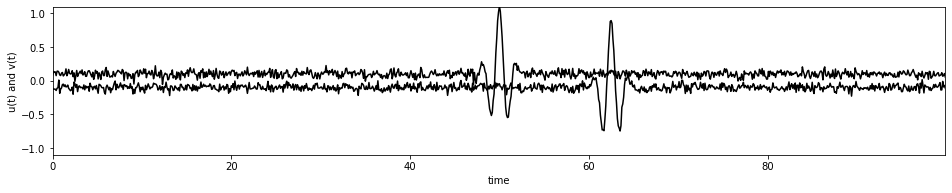

In [2]:
# Set up synthetic time series
N = 1000
Dt = 0.1
t = np.zeros((N,1))
t[:,0] = Dt*np.linspace(0,N-1,N)

# Starttime of the signal (some arbitary ones)
t1 = Dt*4*N/8
t2 = 
tlag_true = t2 - t1

# setup of the signal
w0 = 2*pi*0.5
u = np.zeros((N,1))
v = np.zeros((N,1))

noise_level = 0.04
u[:,0] = (np.multiply( np.cos( w0 * (t-t1) ), np.exp( -np.power((t-t1),2)/2 )) + np.random.normal(0.0,noise_level,(N,1))).ravel();
v[:,0] = (np.multiply( np.cos( w0 * (t-t2) ), np.exp( -np.power((t-t2),2)/2 )) + np.random.normal(0.0,noise_level,(N,1))).ravel();




fig1 = plt.figure(1,figsize=(16,6));
ax1 = plt.subplot(2,1,1);
plt.axis([t[0,0], t[N-1,0], -1.1, 1.1]);
plt.plot( t, u+0.1, 'k-');
plt.plot( t, v-0.1, 'k-');
plt.xlabel('time');
plt.ylabel('u(t) and v(t)');

#### 1.1 Cross correlation on synthetic data
CC the signal using 
```python
cc = np.correlate(a, b, mode='full')
```

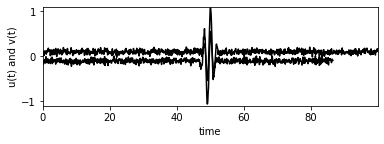

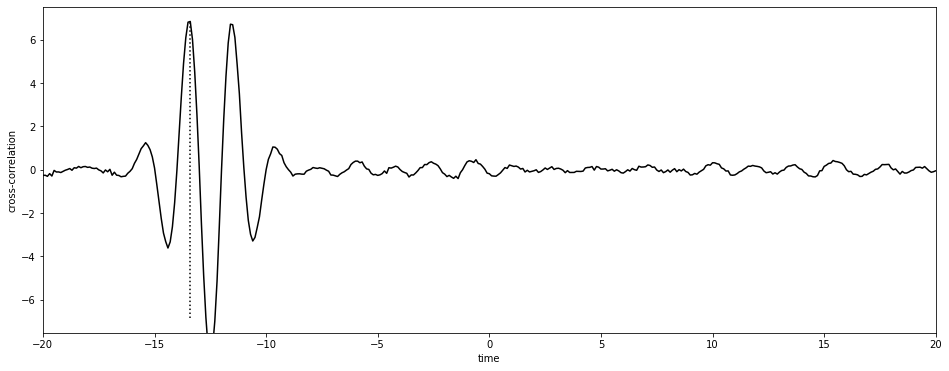

lag: true: 12.50 estimated: 13.40


In [4]:
# cross correlation
Nc = 
c = 
c[:,0] = 

# time asxis for autocorrelation
tau = np.zeros((2*N-1,1));
tau[:,0] = 

# find best lag
Ncenter = (Nc+1)/2;
cmax = np.max(c);
icmax = np.argmax(c);
tlag = -Dt * (icmax-N+1);

# plot lagged timeseries
ax2 = plt.subplot(2,1,2);
plt.axis([t[0,0], t[N-1,0], -1.1, 1.1]);
plt.plot( t, u+0.1, 'k-');
plt.plot( t-tlag, v-0.1, 'k-');
plt.xlabel('time');
plt.ylabel('u(t) and v(t)');

#  plot cross-correlation
fig2 = plt.figure(2,figsize=(16,6));
ax2 = plt.subplot(1,1,1);
plt.axis( [-20, 20, -1.1*cmax, 1.1*cmax] );
plt.plot( tau, c, 'k-');
plt.plot( [-tlag, -tlag], [-cmax, cmax], 'k:');
plt.xlabel('time')
plt.ylabel('cross-correlation');
plt.show();

print( "lag: true: %.2f estimated: %.2f" % (tlag_true, tlag) );

#### 1.2 Cross-correlation on real data
Here we try to cross correlate ozone and radiation data


In [5]:
# using the cross correlation to align two timeseries
# West Point ozone data
D = np.genfromtxt('data/ozone_nohead.txt', delimiter='\t')
[N, M]=D.shape;
t = np.zeros((N,1));
t[:,0] = D[:,0];         # time in days after 1:00 AM on Aug 1, 1993
Dt=1/24;
tmin = t[0,0];
tmax = t[N-1,0];
ozone = np.zeros((N,1));
ozone[:,0] = D[:,1];     # ozone in ppm
radiation = np.zeros((N,1));
radiation[:,0] = D[:,2]; # solar radiation in W/m2
temp = np.zeros((N,1));
temp[:,0] = D[:,3];      # temperature in deg C


# cross correlation
Nc = 2*N-1;
c = np.zeros((Nc,1));
c[:,0] = np.correlate(, mode='full')   #####

# time asxis for autocorrelation
tau = np.zeros((2*N-1,1));
tau[:,0] = Dt*np.linspace(-N+1,N-1,2*N-1);


# find best lag
Ncenter = (Nc+1)/2;
cmax = np.max(c);
icmax = np.argmax(c);
tlag = -Dt * (icmax-N+1);

lagged data, zoomed


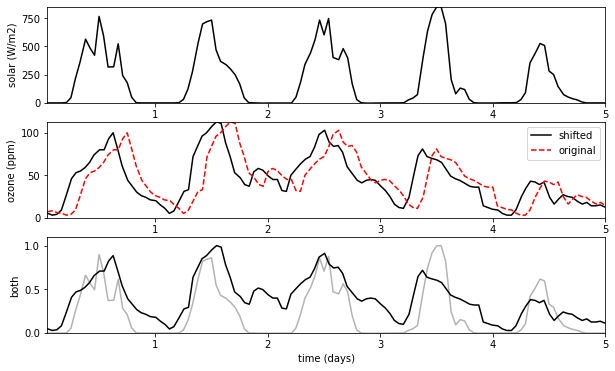

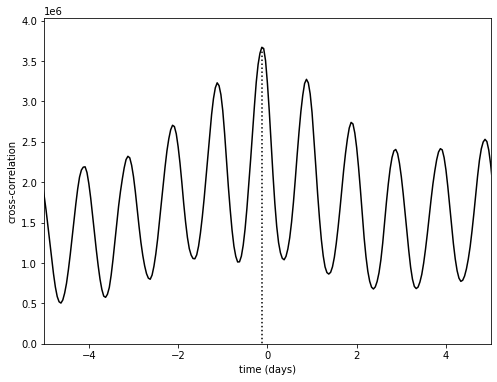

estimated lag: 3.00 hours


In [6]:
# lagged plot, zommed
days=5;
print('lagged data, zoomed');
fig2 = plt.figure(2,figsize=(10,6));

# solar radiation
ax1 = plt.subplot(3,1,1);
plt.axis([t[0,0], t[days*24-1,0], 0, np.max(radiation)]);
plt.plot( t, radiation, 'k-');
plt.xlabel('time (days)');
plt.ylabel('solar (W/m2)');

# ozone
ax2 = plt.subplot(3,1,2);
plt.axis([t[0,0], t[days*24-1,0], 0, np.max(ozone)]);
plt.plot( t-tlag, ozone, 'k-',label='shifted');
plt.plot( t, ozone, 'r--', label='original');
plt.xlabel('time (days)');
plt.ylabel('ozone (ppm)');
plt.legend()

# both
ax3 = plt.subplot(3,1,3);
plt.axis([t[0,0], t[days*24-1,0], 0, 1.1]);
plt.plot( t, radiation/np.max(radiation), 'k-', color=(0.7,0.7,0.7));
plt.plot( t-tlag, ozone/np.max(ozone), 'k-');
plt.xlabel('time (days)');
plt.ylabel('both');

#plot cross-correlation
fig3 = plt.figure(3,figsize=(8,6));
ax2 = plt.subplot(1,1,1);
plt.axis( [-5, 5, 0, 1.1*cmax] );
plt.plot( tau, c, 'k-');
plt.plot( [-tlag, -tlag], [-cmax, cmax], 'k:');
plt.xlabel('time (days)')
plt.ylabel('cross-correlation');
plt.show();

print( "estimated lag: %.2f hours" % (24*tlag) );

### 1.3 Bandpass filter

Z transform of the filter:
$$f(z) = \frac{u(z)}{v(z)} = \frac{\prod^{N_u-1}(z-z^u_j)}{\prod^{N_v-1}(z-z^v_k)}$$

Fourier transform of the filter:
$$f_k =\sum^N_{n-1}f_k exp(-iw_kt_n) =  \sum^N_{n-1}f_kz^{n-1} $$

Try to change the root value, to change the filter from highpass to lowpass
$$(f_1+f_2z)$$

zero at 0.909


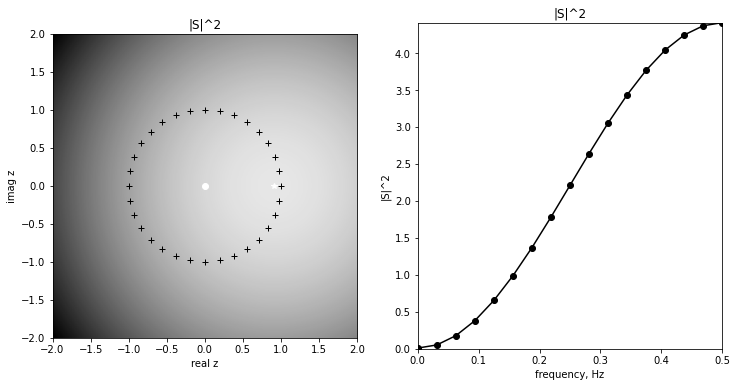

In [13]:
# eda09_10
# complex z-plane analysis of filters, case 1, highpass

### a monomial filter, and its one root
F = np.zeros((2,1));
F[:,0] = [-1, 1.1];
zp = -F[0,0]/F[1,0];  # 0=F1+F2*z  so z=-F1/F2
print("zero at %.3f" % (zp) );





# standard time/frequency setup
N=32;
Dt=1.0;
No2 = floor(N/2);
tmin = 0;
tmax = Dt*(N-1);
t=np.zeros((N,1));
t[:,0]= np.linspace(tmin,tmax,N);
fmax=1/(2.0*Dt);
Df=fmax/No2;
Nf=No2+1;
f=np.zeros((N,1));
f[:,0] = Df * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Dw=2*pi*Df;
w=np.zeros((N,1));
w[:,0] = Dw * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Nw=Nf;
fpos=np.zeros((Nf,1));
fpos[:,0] = Df * np.linspace(0,No2,Nf);
wpos=np.zeros((Nf,1));
wpos[:,0] = Dw * np.linspace(0,No2,Nf);



# complex z-plane
Nz=128;
zmin=-2;
zmax=2;
dz=(zmax-zmin)/(Nz-1);
zr = np.zeros((Nz,1));
zi = np.zeros((Nz,1));
zr[:,0]=np.linspace(zmin,zmax,Nz);
zi[:,0]=np.linspace(zmin,zmax,Nz);

# evaluate filter polynomial everywhere in complex z-plane
S = np.zeros((Nz,Nz));
for n in range(Nz):
    for m in range(Nz):
        S[m,n] = abs( F[0,0] + F[1,0]*(zr[n,0]+complex(0,1)*zi[m,0]) )**2;

# plot amplitude of polynomial
fig1 = plt.figure(1,figsize=(12,6));

# black and white colormap
bw = np.zeros((256,4));
v = 0.9*(256 - np.linspace( 0, 255, 256 ))/255;
bw[:,0] = v;
bw[:,1] = v;
bw[:,2] = v;
bw[:,3] = np.ones(256);
bwcmap = ListedColormap(bw);

ax1 = plt.subplot(1,2,1);
plt.axis( [zmin,zmax,zmin,zmax]);

plt.imshow( S, cmap=bwcmap, vmin=np.min(S), vmax=np.max(S), extent=(zmin,zmax,zmin,zmax) );
plt.xlabel('real z');
plt.ylabel('imag z');
plt.title('|S|^2');

# plot Fourier transform points on the unit circle
plt.plot(0,0,'wo');
z=np.exp(-complex(0,1)*w*Dt);
plt.plot(np.real(z),np.imag(z),'k+');

# plot zero of filter
plt.plot(np.real(zp),np.imag(zp),'w*');

# plot frequency response of filter

Sz = np.abs( F[0,0]+F[1,0]*z )**2;

ax2 = plt.subplot(1,2,2);
plt.axis( [0, fmax, 0, max(Sz)] );

plt.xlabel('frequency, Hz');
plt.ylabel('|S|^2');
plt.title('|S|^2');
plt.plot(fpos,Sz[0:Nf,0],'k-');
plt.plot(fpos,Sz[0:Nf,0],'ko');

plt.show();

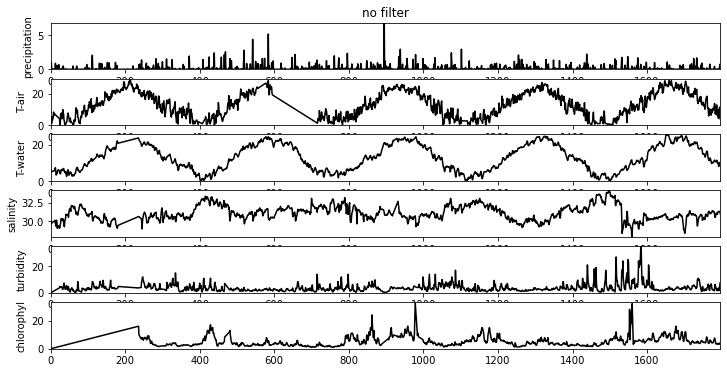

In [25]:
# eda09_15
# read Reynolds Channel Water Quality dataset and plot it
# columns are days, precip, air_temp, water_temp, salinity, turbidity, chlorophyl


# load data
D = np.genfromtxt('data/reynolds_interpolated.txt', delimiter='\t')
[N, M]=D.shape;
t = np.zeros((N,1));
t[:,0] = D[:,0];         # time in days 
Dt=t[1,0]-t[0,0];
tmin = t[0,0];
tmax = t[N-1,0];

def plot_Reynolds(D,N,t,fhigh=None,flow=None):
    # rename
    p = np.zeros((N,1));
    at = np.zeros((N,1));
    wt = np.zeros((N,1));
    s = np.zeros((N,1));
    tb = np.zeros((N,1));
    c = np.zeros((N,1));
    p[:,0] = D[:,1];        # precipitation, inches
    at[:,0] = D[:,2];       # air temperature, deg C
    wt[:,0] = D[:,3];       # water temperature, deg C
    s[:,0] = D[:,4];        # salinity, practical salinity units
    tb[:,0] = D[:,5];       # turbidity, (no units given)
    c[:,0] = D[:,6];        # chlorophyl, micrograms per liter

    fig1 = plt.figure(figsize=(12,6));

    # plotting limits
    itmin=0;
    itmax=N;
    tmin=t[itmin];
    tmax=t[itmax-1];

    ax1 = plt.subplot(6,1,1);
    plt.axis( [tmin, tmax, np.min(p[itmin:itmax,0]), np.max(p[itmin:itmax,0])]);
    plt.plot(t, p, 'k-' );
    plt.ylabel('precipitation');
    if fhigh is None:
        plt.title('no filter')
    else:
        plt.title("data filtered bwetween periods of %.1f and %.1f days" % (1/fhigh,1/flow));

    ax2 = plt.subplot(6,1,2);
    plt.axis( [tmin, tmax, np.min(at[itmin:itmax,0]), np.max(at[itmin:itmax,0])]);
    plt.plot(t, at, 'k-' );
    plt.ylabel('T-air');

    ax3 = plt.subplot(6,1,3);
    plt.axis( [tmin, tmax, np.min(wt[itmin:itmax,0]), np.max(wt[itmin:itmax,0])]);
    plt.plot(t, wt, 'k-' );
    plt.ylabel('T-water');

    ax4 = plt.subplot(6,1,4);
    plt.axis( [tmin, tmax, np.min(s[itmin:itmax,0]), np.max(s[itmin:itmax,0])]);
    plt.plot(t, s, 'k-' );
    plt.ylabel('salinity');

    ax5 = plt.subplot(6,1,5);
    plt.axis( [tmin, tmax, np.min(tb[itmin:itmax,0]), np.max(tb[itmin:itmax,0])]);
    plt.plot(t, tb, 'k-' );
    plt.ylabel('turbidity');

    ax6 = plt.subplot(6,1,6);
    plt.axis( [tmin, tmax, np.min(c[itmin:itmax,0]), np.max(c[itmin:itmax,0])]);
    plt.plot(t, c, 'k-' );
    plt.ylabel('chlorophyl');
    
    plt.show();
    
plot_Reynolds(D,N,t)

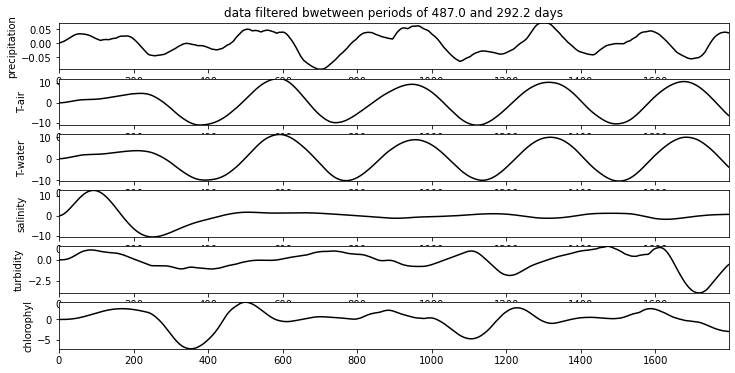

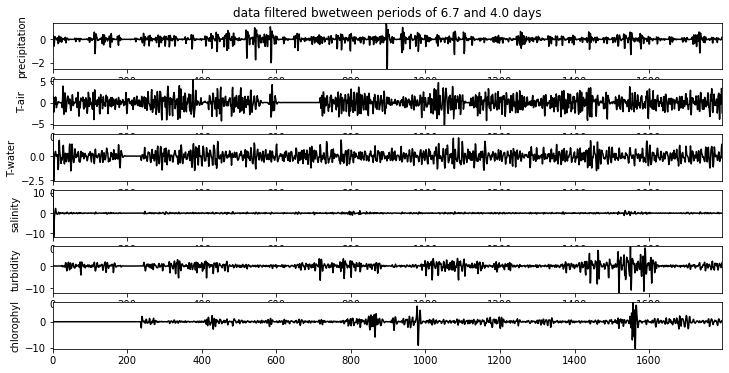

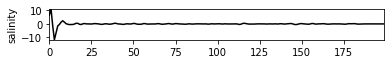

In [41]:

# low pass filter
fcenter = 1/365.25;
flow = 0.75*fcenter;
fhigh =1.25*fcenter;

# bandpass filter
d = np.zeros((N,1));
Df = np.zeros((N,M));
Df[:,0] = D[:,0];
for i in range(1,M):
    d[:,0] = D[:,i];
    [z, u, v] = chebyshevfilt(d, Dt, flow, fhigh);
    Df[:,i] = z.ravel();

plot_Reynolds(Df,N,t,flow,fhigh)



fcenter = 1/5;
flow = 0.75*fcenter;
fhigh =1.25*fcenter;


# bandpass filter
d = np.zeros((N,1));
Df = np.zeros((N,M));
Df[:,0] = D[:,0];
for i in range(1,M):
    d[:,0] = D[:,i];
    [z, u, v] = chebyshevfilt(d, Dt, flow, fhigh);
    Df[:,i] = z.ravel();

plot_Reynolds(Df,N,t,flow,fhigh)


# Zoom into the start of salinity

s[:,0] = Df[:,4]
# plotting limits
itmin=0;
itmax=200;
tmin=t[itmin];
tmax=t[itmax-1];
ax4 = plt.subplot(6,1,4);
plt.axis( [tmin, tmax, np.min(s[itmin:itmax,0]), np.max(s[itmin:itmax,0])]);
plt.plot(t, s, 'k-' );
plt.ylabel('salinity');

### 1.4 Signal processing before bandpass
- demean
- taper

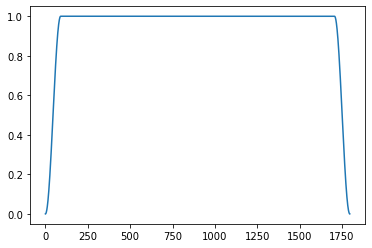

In [31]:
import scipy
taper = scipy.signal.tukey(N,alpha=0.1)
plt.plot(taper)

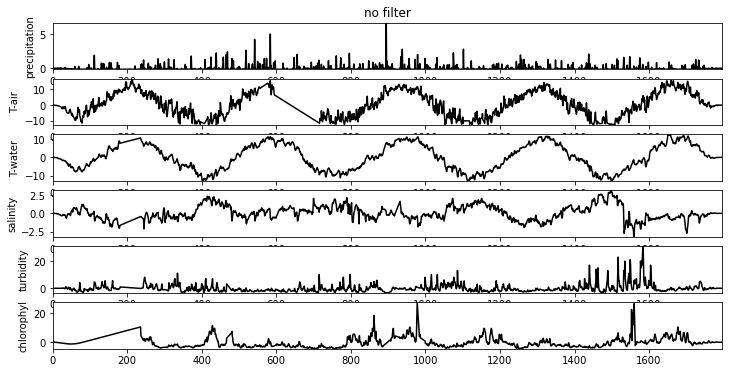

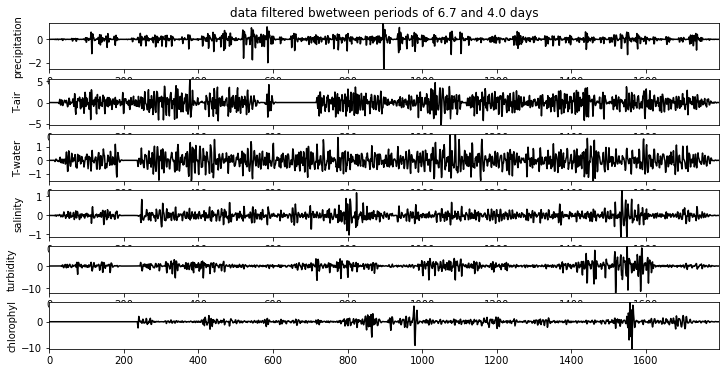

In [38]:
fcenter = 1/5;
flow = 0.75*fcenter;
fhigh =1.25*fcenter;


# bandpass filter
d = np.zeros((N,M));
Df = np.zeros((N,M));
Df[:,0] = D[:,0];
for i in range(1,M):
    # Demean
    d[:,i] = D[:,i]
    # Taper
    d[:,i] = np.multiply( d[:,i], taper ).ravel();
    [z, u, v] = chebyshevfilt(d[:,i], Dt, flow, fhigh);
    Df[:,i] = z.ravel();

# plot processed
plot_Reynolds(d,N,t)
# plot bandpassed
plot_Reynolds(Df,N,t,flow,fhigh)

#### Additional

- Try bandpass the following signal one with hamming, one without 

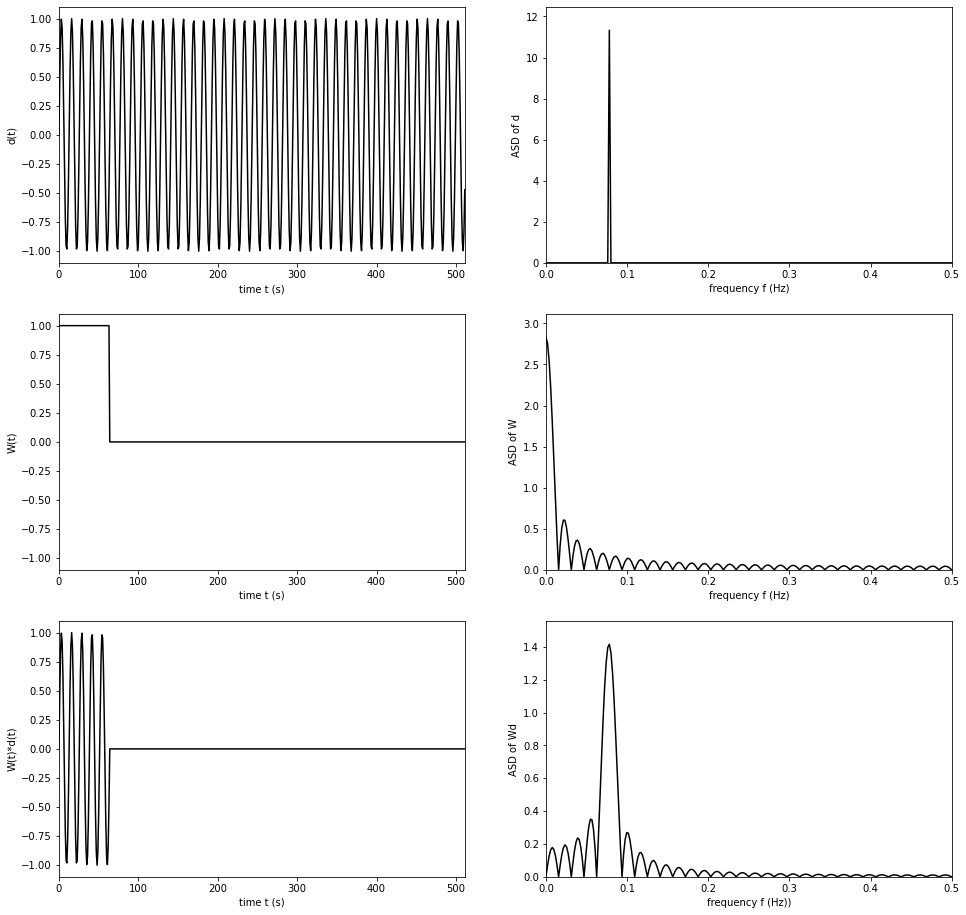

In [3]:
# eda09_19
# demonsrate effect of windowing on power spectral density
# boxcar window

# standard time/frequency definitions
N=512;
Dt=1.0;
t = np.zeros((N,1));
t[:,0] = Dt*np.linspace(0,N-1,N);
tmin = t[0,0];
tmax=t[N-1,0];
fmax=1/(2.0*Dt);
No2 = floor(N/2);
Df=fmax/No2;
Nf=No2+1;
f=np.zeros((N,1));
f[:,0] = Df * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Dw=2*pi*Df;
w=np.zeros((N,1));
w[:,0] = Dw * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Nw=Nf;
fpos=np.zeros((Nf,1));
fpos[:,0] = Df * np.linspace(0,No2,Nf);
wpos=np.zeros((Nf,1));
wpos[:,0] = Dw * np.linspace(0,No2,Nf);

# boxcar window function, W
W = np.zeros((N,1));
No8 = floor(N/8);
W[0:No8,0]=1;
Wtmax = tmax/8;

# timeseriee
w0 = 40*Dw;
d = np.sin( w0 * t );

# windowed timeseries
Wd = np.zeros((N,1));
Wd[:,0] = np.multiply( W, d ).ravel();

# fourier transform
dfft = np.zeros((N,1), dtype=np.complex );
Wfft = np.zeros((N,1), dtype=np.complex );
Wdfft = np.zeros((N,1), dtype=np.complex );
dfft[:,0] = np.fft.fft(d.ravel());
Wfft[:,0] = np.fft.fft(W.ravel());
Wdfft[:,0] = np.fft.fft(Wd.ravel());

# power spectral density
norm = (Dt**2)/tmax;
ds = np.zeros((Nf,1));
Ws = np.zeros((Nf,1));
Wds = np.zeros((Nf,1));
ds[:,0]=norm*np.power(abs(dfft[0:Nf,0]),2);
Ws[:,0]=norm*np.power(abs(Wfft[0:Nf,0]),2);
Wds[:,0]=norm*np.power(abs(Wdfft[0:Nf,0]),2);

# time domain plot
fig1 = plt.figure(1,figsize=(16,16));
                       
ax1 = plt.subplot(3,2,1);
plt.axis( [0, tmax, -1.1, 1.1] );
plt.plot(t, d, 'k-' );
plt.xlabel('time t (s)');                 
plt.ylabel('d(t)');
                       
ax3 = plt.subplot(3,2,3);
plt.axis( [0, tmax, -1.1, 1.1] );
plt.plot(t, W, 'k-' );
plt.xlabel('time t (s)');                 
plt.ylabel('W(t)');
                       
ax5 = plt.subplot(3,2,5);
plt.axis( [0, tmax, -1.1, 1.1] );
plt.plot(t, Wd, 'k-' );
plt.xlabel('time t (s)');                 
plt.ylabel('W(t)*d(t)');    

                     
# frequency domain plot
ax2 = plt.subplot(3,2,2);
plt.axis( [0, fmax, 0, 1.1*np.max(np.sqrt(ds))] );
plt.plot(fpos, np.sqrt(ds), 'k-' );
plt.xlabel('frequency f (Hz)');                 
plt.ylabel('ASD of d');
                       
ax4 = plt.subplot(3,2,4);
plt.axis( [0, fmax, 0, 1.1*np.max(np.sqrt(Ws))] );
plt.plot(fpos, np.sqrt(Ws), 'k-' );
plt.xlabel('frequency f (Hz)');                 
plt.ylabel('ASD of W');
                       
ax5 = plt.subplot(3,2,6);
plt.axis( [0, fmax, 0, 1.1*np.max(np.sqrt(Wds))] );
plt.plot( fpos, np.sqrt(Wds), 'k-' );
plt.xlabel('frequency f (Hz))');                 
plt.ylabel('ASD of Wd');                     

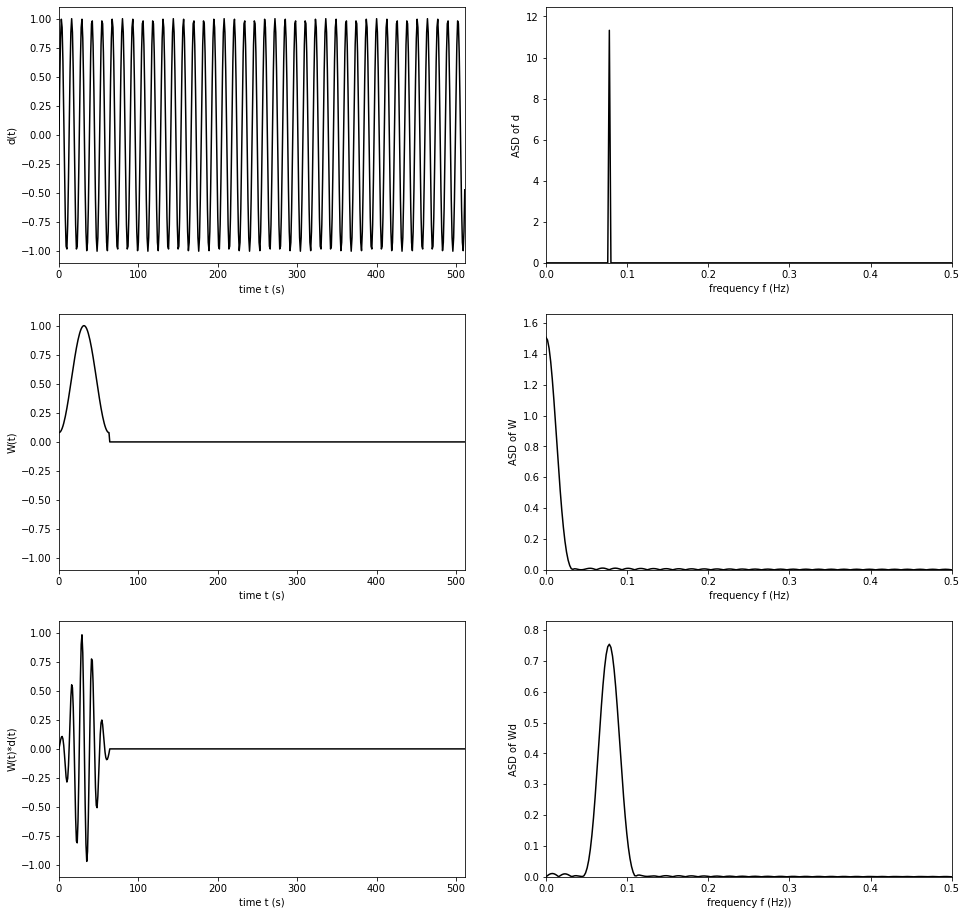

In [4]:
# eda09_20
# demonsrate effect of windowing on power spectral density
# Hamming window

# standard time/frequency definitions
N=512;
Dt=1.0;
t = np.zeros((N,1));
t[:,0] = Dt*np.linspace(0,N-1,N);
tmin = t[0,0];
tmax=t[N-1,0];
fmax=1/(2.0*Dt);
No2 = floor(N/2);
Df=fmax/No2;
Nf=No2+1;
f=np.zeros((N,1));
f[:,0] = Df * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Dw=2*pi*Df;
w=np.zeros((N,1));
w[:,0] = Dw * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Nw=Nf;
fpos=np.zeros((Nf,1));
fpos[:,0] = Df * np.linspace(0,No2,Nf);
wpos=np.zeros((Nf,1));
wpos[:,0] = Dw * np.linspace(0,No2,Nf);

# Hamming window function, W
W = np.zeros((N,1));
Nw = floor(N/8);
W[0:Nw,0]=0.54-0.46*np.cos(2*pi*np.linspace(0,Nw-1,Nw)/(Nw-1));

# timeseriee
w0 = 40*Dw;
d = np.sin( w0 * t );

# windowed timeseries
Wd = np.zeros((N,1));
Wd[:,0] = np.multiply( W, d ).ravel();

# fourier transform
dfft = np.zeros((N,1), dtype=np.complex );
Wfft = np.zeros((N,1), dtype=np.complex );
Wdfft = np.zeros((N,1), dtype=np.complex );
dfft[:,0] = np.fft.fft(d.ravel());
Wfft[:,0] = np.fft.fft(W.ravel());
Wdfft[:,0] = np.fft.fft(Wd.ravel());

# power spectral density
norm = (Dt**2)/tmax;
ds = np.zeros((Nf,1));
Ws = np.zeros((Nf,1));
Wds = np.zeros((Nf,1));
ds[:,0]=norm*np.power(abs(dfft[0:Nf,0]),2);
Ws[:,0]=norm*np.power(abs(Wfft[0:Nf,0]),2);
Wds[:,0]=norm*np.power(abs(Wdfft[0:Nf,0]),2);

# time domain plot
fig1 = plt.figure(1,figsize=(16,16));
                       
ax1 = plt.subplot(3,2,1);
plt.axis( [0, tmax, -1.1, 1.1] );
plt.plot(t, d, 'k-' );
plt.xlabel('time t (s)');                 
plt.ylabel('d(t)');
                       
ax3 = plt.subplot(3,2,3);
plt.axis( [0, tmax, -1.1, 1.1] );
plt.plot(t, W, 'k-' );
plt.xlabel('time t (s)');                 
plt.ylabel('W(t)');
                       
ax5 = plt.subplot(3,2,5);
plt.axis( [0, tmax, -1.1, 1.1] );
plt.plot(t, Wd, 'k-' );
plt.xlabel('time t (s)');                 
plt.ylabel('W(t)*d(t)');    

                     
# frequency domain plot
ax2 = plt.subplot(3,2,2);
plt.axis( [0, fmax, 0, 1.1*np.max(np.sqrt(ds))] );
plt.plot(fpos, np.sqrt(ds), 'k-' );
plt.xlabel('frequency f (Hz)');                 
plt.ylabel('ASD of d');
                       
ax4 = plt.subplot(3,2,4);
plt.axis( [0, fmax, 0, 1.1*np.max(np.sqrt(Ws))] );
plt.plot(fpos, np.sqrt(Ws), 'k-' );
plt.xlabel('frequency f (Hz)');                 
plt.ylabel('ASD of W');
                       
ax5 = plt.subplot(3,2,6);
plt.axis( [0, fmax, 0, 1.1*np.max(np.sqrt(Wds))] );
plt.plot( fpos, np.sqrt(Wds), 'k-' );
plt.xlabel('frequency f (Hz))');                 
plt.ylabel('ASD of Wd');                     
                       